In [37]:
import pandas as pd 
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns

In [38]:
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv') 

In [39]:
train.head( )

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [40]:
train['sentiment'].isna().sum() # 0
train['sentiment'].value_counts() # Neutral, negative, positive

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [41]:
train['text'].isna().sum() # 1
train = train.dropna()

In [42]:
train["length"] = train["text"].apply(lambda x : len(x))
train["length"] = train["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train["length"].describe())
print()

print("Test Length Stat")
print(train["length"].describe())

Train Length Stat
count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: length, dtype: float64

Test Length Stat
count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: length, dtype: float64


In [43]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


# Generating Meta-Features

In the previous versions of this notebook,I used Number of words in selected text and main text ,Length of words in text and selected as main meta features,but in the context of this competition where we have to predict selected_text which is a subset of text, more useful features to generate would be :-

    - Difference In Number Of words of Selected_text and Text
    - Jaccard Similarity Scores between text and Selected_text

Thus it will not be useful for us to generate features we used before as they are of no importance here

For what who don't know what Jaccard Similarity is : https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/


In [44]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [45]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [46]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [47]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) # Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) # Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] # Difference in Number of words text and Selected Text

In [48]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_87608\1923648379.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\simon\AppData\Local\Temp\ipykernel_87608\1923648379.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




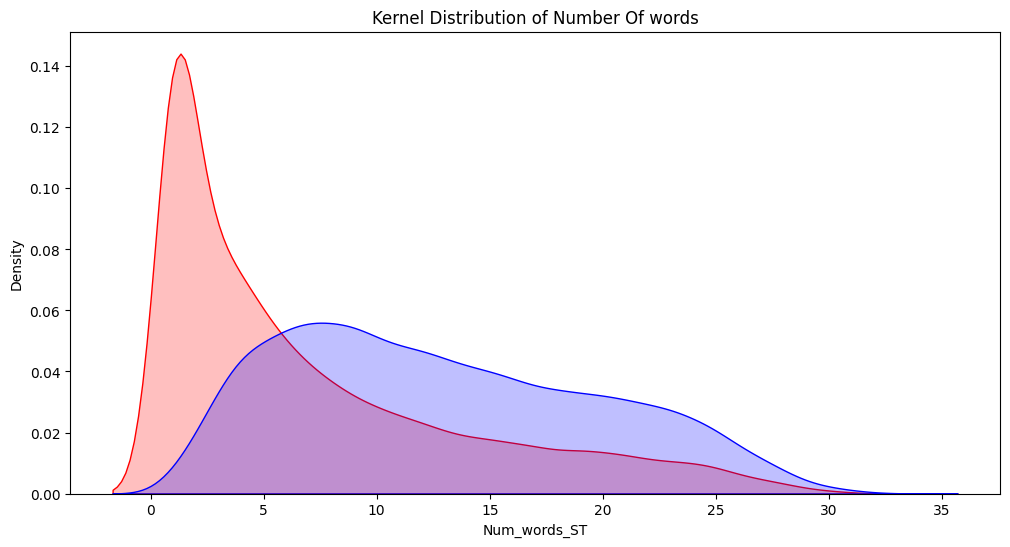

In [49]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

#### The number of words plot is really interesting
The tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

### It is more interesting to see the differnce in number of words and jaccard_scores across different Sentiments


C:\Users\simon\AppData\Local\Temp\ipykernel_87608\828133618.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\simon\AppData\Local\Temp\ipykernel_87608\828133618.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




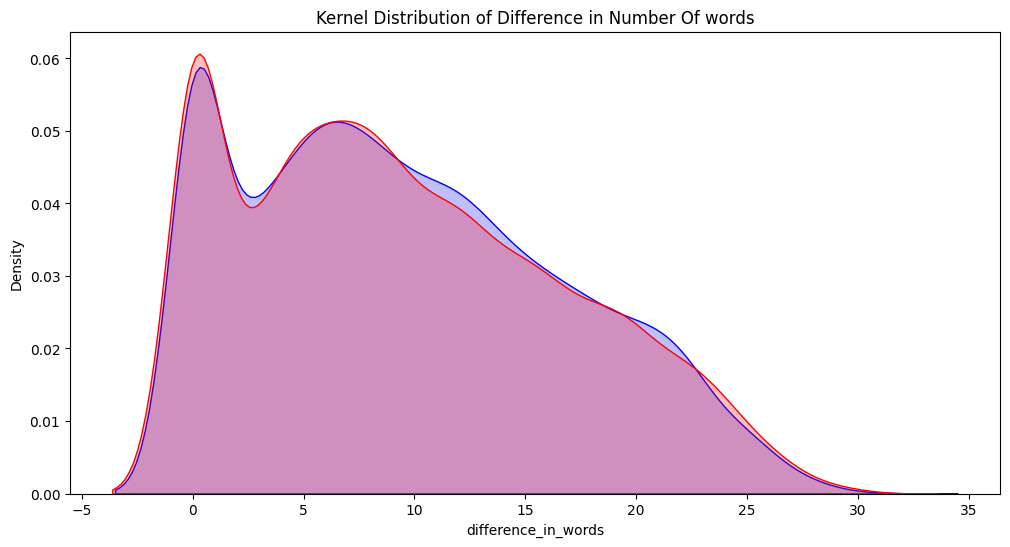

In [50]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

# Cleaning

In [51]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

#                                     #  
#   REMEMBER TO JOIN TOKENS AFTER EDA #
#                                     #

# Preprocess text function
def preprocess_text(text):
    # URLs, special characters/numbers, lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = text.lower()
    # Tokenization and processing
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens  


In [52]:
# Apply preprocess_text to your DataFrame
train['clean_text'] = train['text'].apply(preprocess_text)
train['clean_selected_text'] = train['selected_text'].apply(preprocess_text)

In [53]:
train.head()

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,"[responded, going]","[responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,"[sooo, sad, miss, san, diego]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,"[bos, bullying]",[bullying]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,"[interview, leave, alone]","[leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,"[son, put, release, already, bought]",[son]


In [20]:
# Modify the Counter operation
train['temp_list'] = train['clean_selected_text']
top = Counter([item for sublist in train['temp_list'] for item in sublist])

# Create DataFrame for the top words
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]  # Skip the first row if needed
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1261
2,love,979
3,happy,856
4,get,829
5,like,797
6,go,750
7,work,659
8,time,623
9,going,597
10,today,586


## Most common words sentiment wise

In [54]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [59]:
train.head()

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,"[responded, going]","[responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,"[sooo, sad, miss, san, diego]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,"[bos, bullying]",[bullying]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,"[interview, leave, alone]","[leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,"[son, put, release, already, bought]",[son]


In [60]:
# Positive
top = Counter([item for sublist in Positive_sent['clean_selected_text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,831
1,love,748
2,happy,733
3,day,484
4,thanks,445
5,great,364
6,fun,289
7,mother,272
8,nice,267
9,hope,252


In [61]:
# Negative
top = Counter([item for sublist in Negative_sent['clean_selected_text'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')



,Common_words,count
1,sad,344
2,sorry,300
3,hate,260
4,bad,246
5,suck,209
6,feel,173
7,sick,167
8,like,164
9,hurt,162
10,tired,146


In [62]:
# Neutral
top = Counter([item for sublist in Neutral_sent['clean_selected_text'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greys')

,Common_words,count
1,day,649
2,go,610
3,work,505
4,going,476
5,lol,468
6,time,461
7,like,453
8,got,447
9,today,443
10,one,433


## Unique words Sentiment-Wise

In [63]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['clean_selected_text']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['clean_selected_text']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['clean_selected_text']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words




raw_text = [word for word_list in train['clean_selected_text'] for word in word_list]

In [64]:
# Positive
Unique_Positive= words_unique('positive', 10, raw_text)
print("The top 10 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 10 unique words in Positive Tweets are:


,words,count
0,congratulation,27
1,thnx,8
2,lov,8
3,happ,7
4,talented,7
5,brilliant,7
6,appreciated,6
7,goood,6
8,blessing,5
9,amazin,5


In [65]:
# Negative
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,saddest,7
1,hated,6
2,weak,6
3,suffering,6
4,rly,5
5,fed,5
6,devastated,5
7,pissing,5
8,nauseous,4
9,allergic,4


In [66]:
# Neutral
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Greys')

The top 10 unique words in Neutral Tweets are:


,words,count
0,store,32
1,9,31
2,shop,22
3,myspace,18
4,boyfriend,17
5,catching,16
6,50,16
7,40,16
8,setting,16
9,paper,16


In [ ]:
train.head()
train_clean = pd.read_csv('train_clean.csv')

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text,temp_list
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,NaN,NaN,NaN
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,NaN,NaN,NaN
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,NaN,NaN,NaN
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,NaN,NaN,NaN
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,NaN,NaN,NaN


In [ ]:
columns_to_clean = ['clean_text', 'clean_selected_text', 'temp_list']
for col in columns_to_clean:
    # Convert to string to ensure the replace method works correctly
    train_clean[col] = train_clean[col].astype(str)
    
    # Replace square brackets
    train_clean[col] = train_clean[col].str.replace(r"\[|\]", "", regex=True)

In [ ]:
train_clean.head()

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text,temp_list
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,"['responded', 'going']","['responded', 'going']","['responded', 'going']"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,"['sooo', 'sad', 'miss', 'san', 'diego']","['sooo', 'sad']","['sooo', 'sad']"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,"['bos', 'bullying']",['bullying'],['bullying']
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,"['interview', 'leave', 'alone']","['leave', 'alone']","['leave', 'alone']"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,"['son', 'put', 'release', 'already', 'bought']",['son'],['son']


In [ ]:
columns_to_join = ['clean_text']
for col in columns_to_join:
    # Join the tokens into a single string if they are not already
    train_clean[col] = train_clean[col].apply(lambda x: ' '.join(x.split()) if isinstance(x, str) else x)

In [ ]:
train_clean.head()

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text,temp_list
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,responded going,"'responded', 'going'","'responded', 'going'"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,sooo sad miss san diego,"'sooo', 'sad'","'sooo', 'sad'"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,bos bullying,'bullying','bullying'
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,interview leave alone,"'leave', 'alone'","'leave', 'alone'"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,son put release already bought,'son','son'


In [ ]:
def clean_and_join_text(text):
    # Remove single quotes, commas, and strip extra whitespace
    cleaned_text = text.replace("'", "").replace(",", " ")
    return ' '.join(cleaned_text.split())

train_clean['clean_text'] = train_clean['clean_text'].apply(clean_and_join_text)

# since it's still not joined:


In [ ]:
def preprocess_text(text):
    # URLs, special characters/numbers, lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = text.lower()
    # Tokenization and processing
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)  # Join the tokens back into a string

# Apply the modified function to your DataFrame
train_clean['clean_text'] = train['text'].apply(preprocess_text)
train_clean['clean_selected_text'] = train['selected_text'].apply(preprocess_text)


0    r                                             ...
1    s                                             ...
2    b                                             ...
3    i                                             ...
4    s                                             ...
Name: clean_text, dtype: object

In [ ]:
train_clean['clean_text'] = train_clean['clean_text'].apply(lambda x: x.replace(" ", "") if isinstance(x, str) else x)
train_clean['clean_selected_text'] = train_clean['clean_selected_text'].apply(lambda x: x.replace(" ", "") if isinstance(x, str) else x)
train_clean.head()

,textID,text,selected_text,sentiment,length,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text,clean_selected_text,temp_list
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,1.000000,7,7,0,respondedgoing,respondedgoing,"'responded', 'going'"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,0.200000,2,10,8,sooosadmisssandiego,sooosad,"'sooo', 'sad'"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,0.166667,2,5,3,bosbullying,bullying,'bullying'
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,0.600000,3,5,2,interviewleavealone,leavealone,"'leave', 'alone'"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,0.214286,3,14,11,sonputreleasealreadybought,son,'son'


In [ ]:
tweets_df = train_clean.copy()

# Training and testing sets
X_train_raw, X_val_raw, y_train, y_val = train_test_split(tweets_df['clean_selected_text'], tweets_df['sentiment'], test_size=0.2, random_state=42)

# Vectorize. Fitting on training data only to avoid data leakage
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
X_val = tfidf_vectorizer.transform(X_val_raw).toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Predict sentiment for a new tweet
def predict_sentiment(tweet):
    tweet_processed = tfidf_vectorizer.transform([tweet])
    return model.predict(tweet_processed)[0]


C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.6717612809315866

Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.40      0.56      1572
     neutral       0.56      0.99      0.72      2236
    positive       0.95      0.51      0.66      1688

    accuracy                           0.67      5496
   macro avg       0.82      0.63      0.65      5496
weighted avg       0.79      0.67      0.65      5496

Predicted Sentiment: negative


In [ ]:
# Prediction
new_tweet = "Although I don't like Harry Potter, I still watched it and it was pretty good"
predicted_sentiment = predict_sentiment(new_tweet)
print("Predicted Sentiment:", predicted_sentiment)

NameError: name 'predict_sentiment' is not defined